<a href="https://colab.research.google.com/github/unclepete-20/lab7-sds/blob/main/lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 7 - Ataques a Modelos de Deep Learning

## Pedro Arriola (20188)

## Preámbulo

La clasificación de malware mediante técnicas de aprendizaje automático y deep learning es una tarea compleja y de gran relevancia en el ámbito de la ciberseguridad. Existen dos enfoques principales para el análisis de malware: análisis estático y análisis dinámico.

- **Análisis estático:** Se caracteriza por su rapidez, ya que no requiere ejecutar el malware. Su principal desafío es la correcta identificación de llamadas sospechosas a DLLs y APIs sin la ejecución del código.
- **Análisis dinámico:** Permite un estudio detallado del comportamiento del malware mediante su ejecución en un entorno controlado, pero es más lento y requiere más recursos.

Utilizando técnicas de visualización avanzadas, se pueden convertir los archivos binarios de malware en imágenes, permitiendo el uso de redes neuronales convolucionales (CNNs), típicamente empleadas en la clasificación de imágenes. Esto ofrece una aproximación interesante y visual al problema del malware, como se sugiere en el artículo "Malware Images: Visualization and Automatic Classification".

### Seguridad en modelos de data science

Los modelos de ML y DL son susceptibles a varios tipos de ciberataques:

- **Ataques de extracción:** Donde se intenta duplicar la funcionalidad del modelo a través de acceso limitado, como las API.
- **Ataques de inferencia:** Permiten al atacante descubrir datos sobre los conjuntos de entrenamiento o inferir características de los datos privados utilizados en el modelo.
- **Ataques de evasión y envenenamiento:** Tienen el objetivo de engañar al modelo para que haga clasificaciones incorrectas o para insertar vulnerabilidades específicas.

En este laboratorio, nos centraremos en construir un modelo de clasificación robusto y en evaluar su vulnerabilidad ante estos ataques utilizando herramientas avanzadas como el Adversarial Robustness Toolbox.

### Preparación y Pre-procesamiento de Datos

#### Carga y Análisis del Dataset

Utilizaremos el framework TensorFlow junto con Keras para cargar y pre-procesar las imágenes de malware. El dataset está organizado en distintas carpetas correspondientes a cada familia de malware y contiene imágenes en formato PNG. El objetivo inicial es cargar estas imágenes y analizar la distribución de las mismas entre las distintas familias.

1. **Carga del Dataset**: Utilizamos `ImageDataGenerator` de Keras para facilitar la carga y el pre-procesamiento de imágenes. Este herramienta también facilitará la augmentación de datos si fuese necesario más adelante.

2. **Análisis de Datos**: Es crucial entender la cantidad de datos disponibles por cada familia de malware. Familias con muy pocas imágenes podrían no ser adecuadas para el entrenamiento del modelo, ya que podrían no generalizar bien o incluso causar overfitting.

#### Visualización de Datos

Es importante visualizar las imágenes del dataset para tener una mejor comprensión de los datos con los que estamos trabajando. La visualización ayuda a detectar si hay algún problema obvio con las imágenes, como errores en la etiquetación o inconsistencias en los datos.

In [5]:
import tensorflow as tf

# Comprobar dispositivos disponibles
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar TensorFlow para usar la GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        # Error en caso de que la configuración de la GPU falle
        print(e)
else:
    print("No GPU found, using CPU instead.")

Using GPU: /physical_device:GPU:0


Found 9339 images belonging to 25 classes.
{'Adialer.C': 0, 'Agent.FYI': 1, 'Allaple.A': 2, 'Allaple.L': 3, 'Alueron.gen!J': 4, 'Autorun.K': 5, 'C2LOP.P': 6, 'C2LOP.gen!g': 7, 'Dialplatform.B': 8, 'Dontovo.A': 9, 'Fakerean': 10, 'Instantaccess': 11, 'Lolyda.AA1': 12, 'Lolyda.AA2': 13, 'Lolyda.AA3': 14, 'Lolyda.AT': 15, 'Malex.gen!J': 16, 'Obfuscator.AD': 17, 'Rbot!gen': 18, 'Skintrim.N': 19, 'Swizzor.gen!E': 20, 'Swizzor.gen!I': 21, 'VB.AT': 22, 'Wintrim.BX': 23, 'Yuner.A': 24}


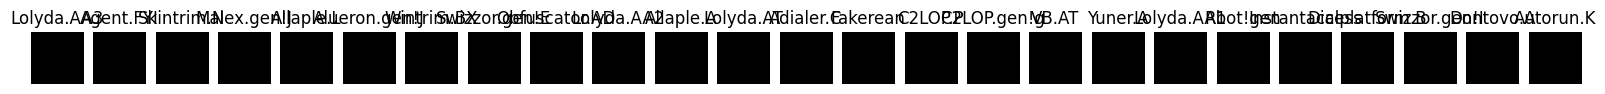

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definir la ruta al dataset
path = '/content/drive/MyDrive/malimg_paper_dataset_imgs'

# Crear un generador de imágenes con reescalado
datagen = ImageDataGenerator(rescale=1./255)

# Cargar imágenes desde el directorio
familias = datagen.flow_from_directory(directory=path, target_size=(64,64), batch_size=10000)

# Obtener la información de las clases
print(familias.class_indices)

# Función generadora que carga imágenes de manera perezosa
def lazy_load_images(directory):
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".png"):
                file_path = os.path.join(subdir, file)
                img = image.load_img(file_path, target_size=(64, 64))
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                img_array = datagen.standardize(img_array)
                yield img_array, subdir.split('/')[-1]  # Yield the image and the class/family name

# Función para encontrar la primera imagen de cada familia utilizando carga perezosa
def find_first_image_of_each_family_lazy(directory):
    found = {}
    for img_array, family_name in lazy_load_images(directory):
        if family_name not in found:
            found[family_name] = img_array[0]
        if len(found) >= len(os.listdir(directory)):  # Assumes each subdirectory is a family
            break
    return found

# Visualizar una imagen por cada familia
def plot_images_lazy(images_info, figsize=(20, 10)):
    f = plt.figure(figsize=figsize)
    for idx, (family_name, img) in enumerate(images_info.items()):
        plt.subplot(1, len(images_info), idx + 1)
        plt.imshow(np.uint8(img))
        plt.title(family_name)
        plt.axis('Off')
    plt.show()

# Obtener y visualizar la primera imagen de cada familia con carga perezosa
images_info = find_first_image_of_each_family_lazy(path)
plot_images_lazy(images_info)

## Construcción y Entrenamiento del Modelo de Deep Learning

### Arquitectura del Modelo

El modelo que utilizaremos es una red neuronal convolucional (CNN), diseñada específicamente para el procesamiento y clasificación de imágenes. Aquí está la descripción detallada de cada capa del modelo:

- **Capa Conv2D**: La primera capa es una capa convolucional (`Conv2D`) con 32 filtros y un tamaño de kernel de (3x3). La función de activación es 'relu'. Esta capa se encarga de extraer características de bajo nivel (como bordes y texturas) de las imágenes.
- **Capa MaxPooling2D**: Sigue una capa de agrupamiento máximo (`MaxPooling2D`) con un tamaño de ventana de (2x2). Esta capa reduce la dimensionalidad espacial de las características entrantes, lo que ayuda a hacer el modelo más eficiente y a reducir el sobreajuste.
- **Capas Conv2D adicionales**: Después del primer bloque, el modelo tiene dos capas convolucionales más, cada una seguida de otra capa de agrupamiento máximo. Estas capas aumentan en número de filtros (64 y 128, respectivamente), permitiendo al modelo aprender características más complejas a medida que se profundiza en la red.
- **Capa Flatten**: A continuación, la capa `Flatten` transforma el mapa de características 2D resultante de las capas convolucionales en un vector 1D. Esto permite que las características extraídas sean utilizadas por las capas densas siguientes.
- **Capa Dense**: La primera capa densa (`Dense`) tiene 128 unidades y utiliza 'relu' como función de activación. Esta capa está diseñada para interpretar las características extraídas por las capas convolucionales.
- **Capa Dropout**: Se incluye una capa de `Dropout` con una tasa de 0.5 para reducir el riesgo de sobreajuste. Dropout "apaga" aleatoriamente un conjunto de neuronas durante el entrenamiento, lo que ayuda a que el modelo sea más robusto y menos dependiente de caminos específicos.
- **Capa de Salida**: Finalmente, la capa de salida tiene tantas unidades como familias de malware hay (25 en este caso) y utiliza la función de activación 'softmax'. Esto permite que el modelo haga una predicción de clase multiclase, asignando probabilidades a cada una de las 25 categorías de malware.

### Compilación del Modelo

El modelo se compila con el optimizador Adam, que es una extensión del descenso de gradiente estocástico y generalmente funciona bien en la mayoría de las configuraciones. La tasa de aprendizaje inicial está configurada en 0.001. La función de pérdida utilizada es 'categorical_crossentropy', adecuada para problemas de clasificación multiclase. También estamos rastreando la métrica 'accuracy' durante el entrenamiento.

### Entrenamiento del Modelo

Utilizamos `ImageDataGenerator` para manejar la carga y el preprocesamiento de las imágenes del dataset. Este generador también facilita la división de datos en conjuntos de entrenamiento (70%) y validación (30%). El entrenamiento se lleva a cabo a través de varias épocas, ajustando el número basado en la observación del desempeño del modelo en los datos de entrenamiento y validación para evitar el sobreajuste.

### Guardado del Modelo

Después del entrenamiento, el modelo se guarda en el formato H5, permitiendo su uso posterior sin la necesidad de reentrenar. Esto es crucial para aplicaciones prácticas donde el modelo puede ser desplegado para la clasificación de malware en diferentes entornos.

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Definir el path al dataset
path = '/content/drive/MyDrive/malimg_paper_dataset_imgs'

# Preparar el generador de datos con división para entrenamiento y validación
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)  # 70% entrenamiento, 30% validación

# Generador de entrenamiento
train_generator = train_datagen.flow_from_directory(
    path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Generador de validación
validation_generator = train_datagen.flow_from_directory(
    path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Construir el modelo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(25, activation='softmax')  # Asumiendo 25 familias de malware
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

# Guardar el modelo
model.save('malware_classification_model.h5')

Found 6549 images belonging to 25 classes.
Found 2790 images belonging to 25 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       73856     
                                  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Evaluación del Modelo de Clasificación de Malware

Después de entrenar el modelo durante 10 épocas, hemos obtenido las siguientes métricas de rendimiento en la última época:

- **Pérdida en Entrenamiento**: 0.1624
- **Precisión en Entrenamiento**: 94.54%
- **Pérdida en Validación**: 0.1959
- **Precisión en Validación**: 95.44%

### Interpretación de Resultados

Estos resultados son bastante prometedores y sugieren que el modelo está desempeñándose bien. La alta precisión en ambos conjuntos, entrenamiento y validación, indica que el modelo es capaz de generalizar bien a nuevos datos. Esto es crucial para asegurar que el modelo funcionará de manera efectiva en el mundo real, identificando correctamente diferentes familias de malware basado en sus imágenes.

Métricas disponibles:  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


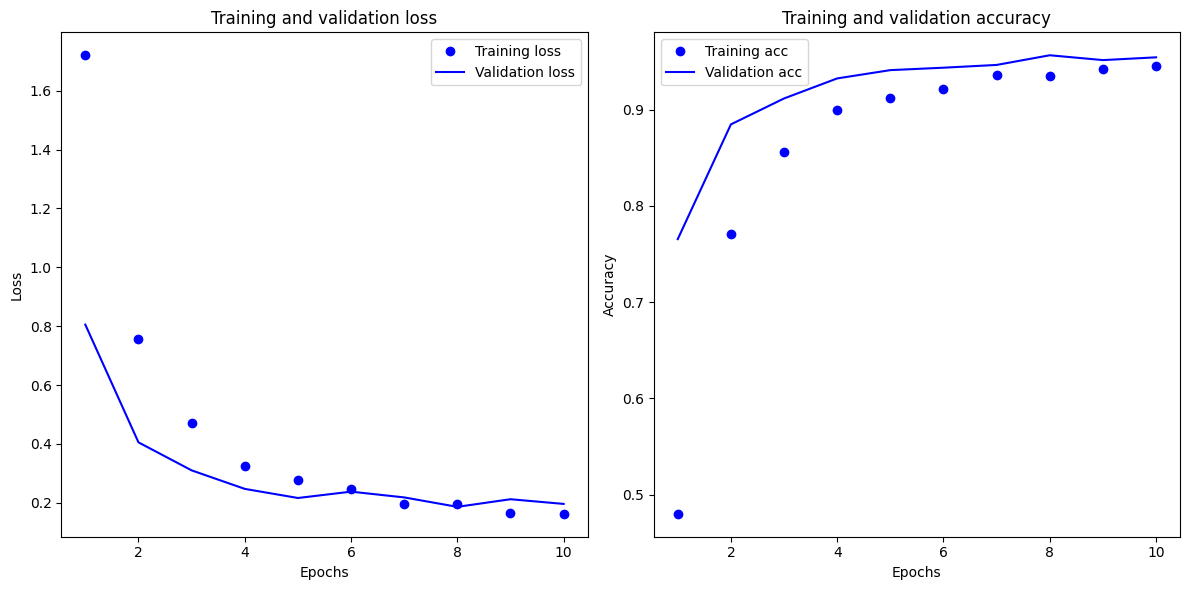

In [9]:
# Acceder al historial de entrenamiento
history_dict = history.history

# Métricas disponibles en el historial
print("Métricas disponibles: ", history_dict.keys())

# Gráficas de pérdida (loss) y precisión (accuracy)
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

# Gráfica de pérdidas
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráfica de precisión
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Ataque 1: Fast Gradient Sign Method (FGSM)

### Descripción del Ataque

El método Fast Gradient Sign Method (FGSM) es un tipo de ataque adversario diseñado para engañar a los modelos de deep learning. Este ataque aprovecha el gradiente de la función de pérdida del modelo con respecto a la entrada (imagen) para crear nuevas imágenes que son visualmente similares a las originales pero modificadas de manera sutil y estratégica para engañar al modelo.

### Objetivo del Ataque

El objetivo de FGSM es modificar la imagen original por medio de la adición de pequeñas perturbaciones (ruido) que resultan en una clasificación incorrecta por parte del modelo. Estas perturbaciones son generadas de manera que maximicen el error de clasificación, basándose en el gradiente de la pérdida con respecto a la entrada.

### Implementación

Utilizaremos el modelo previamente entrenado y aplicaremos el ataque FGSM utilizando el framework Adversarial Robustness Toolbox (ART). Este ataque intentará inducir errores en la clasificación de imágenes que originalmente eran clasificadas correctamente.

In [10]:
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.9 MB/s eta 0:00:00


In [20]:
# Preparar el generador para los datos de prueba
datagen = ImageDataGenerator(rescale=1./255)
test_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/malimg_paper_dataset_imgs',  # Asegúrate de actualizar esta ruta
    target_size=(64, 64),
    batch_size=1,
    class_mode='categorical',
    shuffle=False)

Found 9339 images belonging to 25 classes.


In [13]:
import numpy as np
from tensorflow.keras.models import load_model
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Deshabilitar la ejecución ansiosa
tf.compat.v1.disable_eager_execution()

# Carga del modelo entrenado
model = load_model('malware_classification_model.h5')

# Crear un clasificador ART
classifier = KerasClassifier(model=model, clip_values=(0, 1))

# Instanciar y preparar el ataque FGSM
attack = FastGradientMethod(estimator=classifier, eps=0.1)

# Generar imágenes adversarias y evaluar
x_test_adv = []
y_true = []
for i in range(len(test_generator)):
    x, y = test_generator[i]
    x_adv = attack.generate(x=x)
    x_test_adv.append(x_adv[0])  # Agregar la imagen adversaria
    y_true.append(y[0])          # Agregar la etiqueta verdadera

# Convertir listas a Numpy arrays para evaluación
x_test_adv = np.array(x_test_adv)
y_true = np.array(y_true)

# Evaluar el modelo en datos adversarios
predictions = model.predict(x_test_adv)
accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_true, axis=1))
print(f"Accuracy en datos adversarios: {accuracy*100:.2f}%")

Found 9339 images belonging to 25 classes.
Accuracy en datos adversarios: 10.43%


## Evaluación del Modelo bajo Ataque Adversario FGSM

Tras aplicar el ataque FGSM (Fast Gradient Sign Method) a nuestro modelo de clasificación de malware, observamos una caída dramática en la precisión desde un rendimiento superior al 90% en datos de prueba normales a solo un 10.43% en datos adversarios. Esto resalta una vulnerabilidad significativa del modelo frente a ejemplos adversarios.

### Impacto del Ataque

El ataque FGSM manipula las entradas originales de manera muy efectiva, introduciendo perturbaciones que son imperceptibles para el ojo humano pero suficientes para engañar al modelo. Esto es indicativo de que el modelo es altamente sensible a pequeñas variaciones en sus entradas.

### Implicaciones de Seguridad

En el contexto de la seguridad informática, especialmente en la clasificación de malware, este tipo de vulnerabilidad puede permitir que software malicioso evada la detección alterando mínimamente su código o su representación. La robustez del modelo es, por lo tanto, una área crítica que necesita fortalecimiento.

### Recomendaciones para Mejorar la Robustez

1. **Entrenamiento Adversario**: Incorporar ejemplos adversarios durante el entrenamiento para preparar el modelo contra ataques similares.
2. **Regularización**: Aumentar la regularización puede ayudar a hacer el modelo menos propenso a pequeñas perturbaciones en los datos de entrada.
3. **Exploración de Modelos Alternativos**: Investigar arquitecturas de modelos que sean conocidas por su robustez frente a ataques adversarios.

### Conclusión

La capacidad del modelo para manejar ataques adversarios es crucial para su aplicación en entornos de seguridad. Las estrategias de defensa recomendadas deben ser evaluadas y aplicadas para mejorar la confiabilidad del sistema de clasificación de malware.

## Ataque 2: DeepFool

### Descripción del Ataque

DeepFool es un algoritmo de ataque adversario desarrollado con el objetivo de ser tan eficiente como sea posible en términos de computación y a la vez muy efectivo en encontrar las perturbaciones mínimas necesarias para engañar a los modelos de clasificación. La idea central de DeepFool es calcular iterativamente la perturbación más pequeña que puede engañar al modelo, asumiendo que el modelo es lineal en las proximidades del ejemplo a manipular. DeepFool opera bajo la premisa de que al linearizar el modelo de clasificación, se puede encontrar una forma cerrada para la perturbación óptima que lleva la entrada a cruzar la frontera de decisión del clasificador.

### Metodología del Ataque

El ataque utiliza un enfoque iterativo para mover la imagen de entrada hacia la frontera de decisión del modelo hasta que esta sea cruzada. En cada iteración, DeepFool calcula la dirección y magnitud de la perturbación necesaria para mover la entrada hacia la frontera, basándose en el gradiente de la función de pérdida del modelo respecto a la entrada. Este proceso se repite hasta que la entrada es clasificada incorrectamente, lo cual generalmente requiere solo unas pocas iteraciones debido a la eficiencia del método.

### Resultados Esperados

Dado que DeepFool busca la mínima perturbación necesaria, no esperamos ver cambios visuales significativos en las imágenes perturbadas, aunque estas deberían ser suficientes para engañar al modelo. Este tipo de ataque es particularmente útil para evaluar la robustez de modelos en escenarios cercanos a las condiciones ideales de operación, donde pequeñas perturbaciones no son esperadas para cambiar las decisiones del modelo.

In [24]:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import DeepFool

model_logits = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)

# Configurar el clasificador para ART usando Keras
classifier = KerasClassifier(model=model_logits, use_logits=True, clip_values=(0, 1))

# Configurar y ejecutar el ataque DeepFool
attack = DeepFool(classifier=classifier)

# Generar ejemplos adversarios
x_test, y_test = next(test_generator)
x_test_adv = attack.generate(x=x_test)

# Evaluar el modelo en datos adversarios
predictions = classifier.predict(x_test_adv)
accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))
print(f"Accuracy en datos adversarios DeepFool: {accuracy*100:.2f}%")

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy en datos adversarios DeepFool: 0.00%


## Resultados del Ataque DeepFool

### Evaluación de los Resultados

Tras aplicar el ataque DeepFool, observamos una caída dramática en la precisión del modelo a un **0.00%** en los datos adversarios. Esto indica que el ataque fue capaz de modificar todas las imágenes de prueba de manera que el modelo falló en clasificar correctamente cada una de ellas.

### Análisis del Ataque

DeepFool demostró ser un método de ataque altamente efectivo en nuestro caso, logrando perturbar cada entrada de prueba al punto de ser mal clasificada. Este ataque explota las vulnerabilidades del modelo de manera eficiente, encontrando la mínima perturbación necesaria para inducir errores, lo cual subraya la sensibilidad del modelo a pequeñas variaciones en sus entradas.

### Implicaciones de Seguridad

1. **Alta Sensibilidad a Perturbaciones**: La eficacia del ataque resalta la alta sensibilidad del modelo a perturbaciones sutiles, lo que podría ser crítico en aplicaciones donde la precisión y la confiabilidad son fundamentales.

2. **Necesidad de Robustez Mejorada**: La vulnerabilidad mostrada subraya la importancia de implementar técnicas para aumentar la robustez del modelo, como el entrenamiento adversario, que pueden ayudar a preparar el modelo contra ataques similares.

3. **Evaluación y Pruebas Continuas**: Es crucial continuar evaluando y probando los modelos con nuevas y diversas técnicas de ataque para asegurar su robustez y fiabilidad a lo largo del tiempo.

### Conclusión

Los resultados del ataque DeepFool son un recordatorio poderoso de que la seguridad y la robustez deben ser una prioridad en el desarrollo de modelos de machine learning. Asegurar que los modelos pueden resistir ataques adversarios no solo mejora su eficacia, sino también su confianza y fiabilidad en aplicaciones prácticas. Es imperativo considerar estos aspectos en las etapas tempranas del diseño y desarrollo del modelo.